In [1]:
'''This notebook is designed to test the viability and statistical properties of the gamma poisson mixture
vs a negative binomial in tau leaping. '''

'This notebook is designed to test the viability and statistical properties of the gamma poisson mixture\nvs a negative binomial in tau leaping. '

In [2]:
import numpy as np 
import matplotlib.pyplot as plt
from scipy.stats import poisson
from scipy.special import logsumexp


days = 100
delta_t = 0.1 
initial_cond = np.array([500,5,0])
rng_poisson = np.random.default_rng(0)

def model(theta,rng,*,days,delta_t,num_runs = 1,initial_cond,noise = 'poisson'): 
    
    beta,gamma,r = theta

    state = np.zeros((num_runs,3,days * int(1/delta_t)))

    #Initial condition
    state[:,:,0] = initial_cond

    N = np.sum(state[0,:,0])

    for t in range(1,int(1/delta_t) * days): 

        #Rate equations
        if(noise == 'poisson'):
            dN_SI = rng.poisson(lam = np.maximum(beta * (state[:,0,t-1] * state[:,1,t-1]/N) * delta_t,0))
        elif(noise == 'negative binomial'):
            lam =  np.maximum(beta * (state[:,0,t-1] * state[:,1,t-1]/N) * delta_t,0)
            dN_SI = rng.negative_binomial(p = r/(r + lam),n = r)

        dN_SI = np.minimum(dN_SI,state[:,0,t-1])
        if(noise == 'poisson'): 
            dN_IR = rng.poisson(np.maximum(state[:,1,t-1] * gamma * delta_t,0))
        elif(noise == 'negative binomial'):
            lam = np.maximum(state[:,1,t-1] * gamma * delta_t,0)
            dN_IR = rng.negative_binomial(p = r/(r+lam),n=r)
        
        dN_IR = np.minimum(dN_IR,state[:,1,t-1])


        state[:,0,t] = state[:,0,t-1] - dN_SI
        state[:,1,t] = state[:,1,t-1] + dN_SI - dN_IR
        state[:,2,t] = state[:,2,t-1] + dN_IR

    return state

theta = (0.3,0.1,1.) #Real parameters
state_poisson = model(theta,rng_poisson,days = days,delta_t = delta_t,num_runs = 1000,initial_cond=initial_cond)

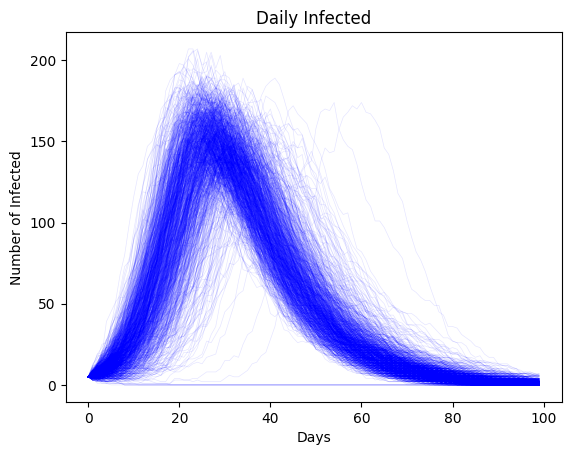

In [3]:
#Extract the data daily
data_poisson = state_poisson[:,:,::int(1/delta_t)]

plt.title('Daily Infected')
plt.xlabel('Days')
plt.ylabel('Number of Infected')
plt.plot(np.arange(0,days,1),data_poisson[:,1,:].T,lw = 0.5,color = 'blue',alpha = 0.1)
plt.show()

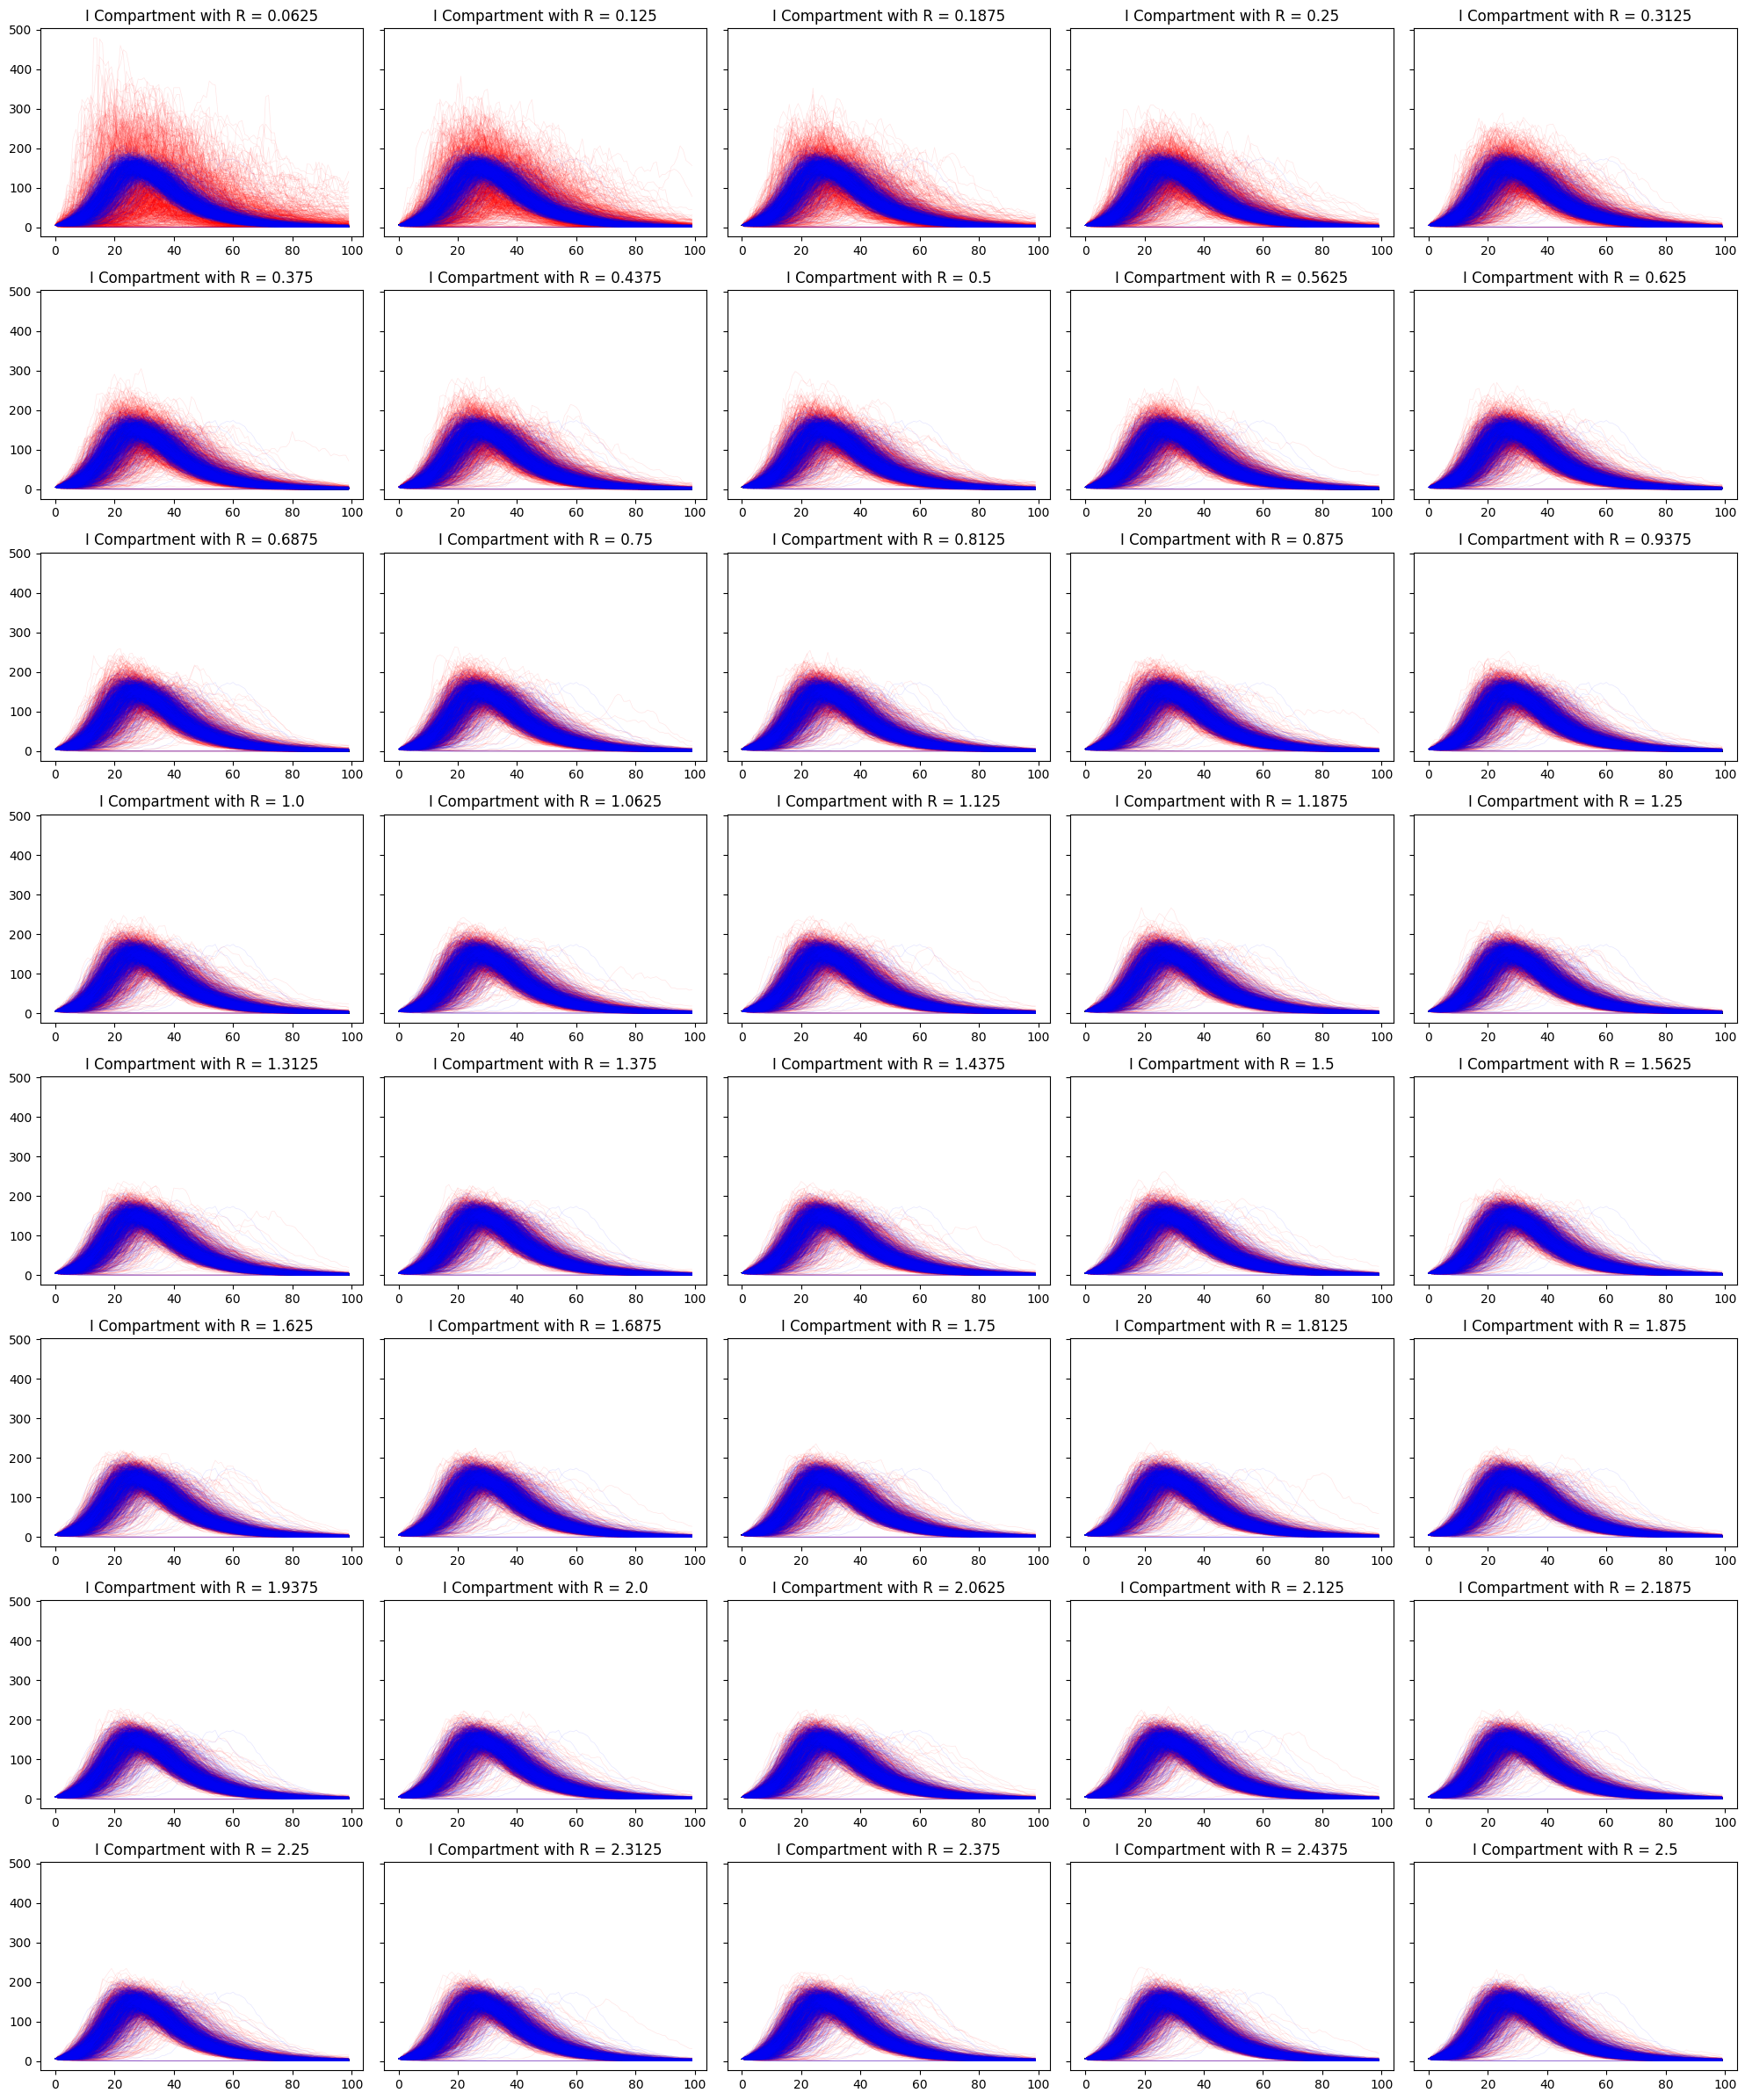

In [4]:
import math

# Example values
step = 0.0625
r_sched = np.arange(0.0625, 2.5 + step, step)
t_range = np.arange(0, days, 1)

max_cols = 5  # <= adjust freely
n_plots = len(r_sched)
ncols = min(max_cols, n_plots)
nrows = math.ceil(n_plots / ncols)

fig, axes = plt.subplots(nrows=nrows, ncols=ncols,
                         sharey=True, figsize=(4*ncols, 3*nrows))

axes = np.atleast_1d(axes).ravel()  # flatten for easy indexing

for idx, r in enumerate(r_sched):
    ax = axes[idx]

    theta = (0.3,0.1,r)

    state = model(theta, rng_poisson, days=days, delta_t=delta_t, 
                  num_runs=1000, initial_cond=initial_cond, noise='negative binomial')
    
    data = state[:, :, ::int(1/delta_t)]
    
    ax.plot(t_range, data[:,1,:].T, lw=0.5, color='red', alpha=0.1)
    ax.plot(t_range, data_poisson[:,1,:].T, lw=0.5, color='blue', alpha=0.1)
    ax.set_title(f'I Compartment with R = {r}')

# Hide unused axes
for j in range(idx+1, len(axes)):
    axes[j].set_visible(False)

plt.tight_layout()
plt.show()

In [5]:
'''Now we want to see if the overdispersion parameter is learnable via the 
IF2 algorithm. In the following cell we generate a dataset from the NB SIR tau leap model with beta = 0.3, gamma = 0.1, and r = 0.25'''

'Now we want to see if the overdispersion parameter is learnable via the \nIF2 algorithm. In the following cell we generate a dataset from the NB SIR tau leap model with beta = 0.3, gamma = 0.1, and r = 0.25'

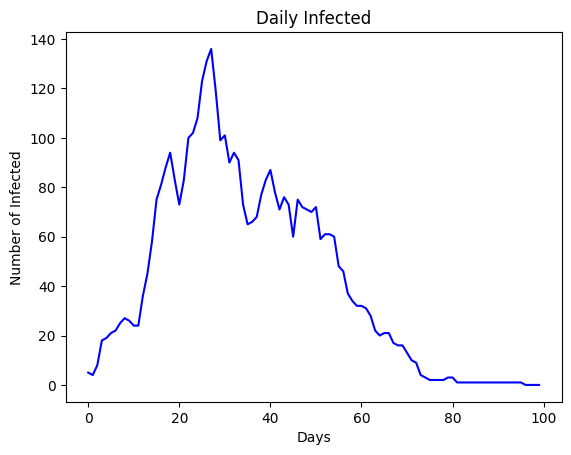

In [6]:
pf_rng = np.random.default_rng(0)
theta = (0.3,0.1,0.1875) #Real parameters
state_real = model(theta,pf_rng,days = days,delta_t = delta_t,num_runs = 1,initial_cond=initial_cond,noise = 'negative binomial')


#Extract the data daily
data_real = state_real[:,1,::int(1/delta_t)].squeeze()

plt.title('Daily Infected')
plt.xlabel('Days')
plt.ylabel('Number of Infected')
plt.plot(np.arange(0,days,1),data_real,color = 'blue')
plt.show()

In [7]:
def single_step(theta,rng,*,delta_t,num_runs = 1,initial_cond,noise = 'poisson',log = False): 
    
    beta,gamma,r = theta

    if(log): 
        beta = np.exp(beta)
        gamma = np.exp(gamma)
        r = np.exp(r)
    
    state = np.zeros((num_runs,3,int(1/delta_t)))

    #Initial condition
    state[:,:,0] = initial_cond

    N = np.sum(state[0,:,0])

    for t in range(1,int(1/delta_t)): 

        #Rate equations
        if(noise == 'poisson'):
            dN_SI = rng.poisson(lam = np.maximum(beta * (state[:,0,t-1] * state[:,1,t-1]/N) * delta_t,0))
        elif(noise == 'negative binomial'):
            lam =  np.maximum(beta * (state[:,0,t-1] * state[:,1,t-1]/N) * delta_t,0)
            dN_SI = rng.negative_binomial(p = r/(r + lam),n = r)

        dN_SI = np.minimum(dN_SI,state[:,0,t-1])
        if(noise == 'poisson'): 
            dN_IR = rng.poisson(np.maximum(state[:,1,t-1] * gamma * delta_t,0))
        elif(noise == 'negative binomial'):
            lam = np.maximum(state[:,1,t-1] * gamma * delta_t,0)
            dN_IR = rng.negative_binomial(p = r/(r+lam),n=r)
        
        dN_IR = np.minimum(dN_IR,state[:,1,t-1])


        state[:,0,t] = state[:,0,t-1] - dN_SI
        state[:,1,t] = state[:,1,t-1] + dN_SI - dN_IR
        state[:,2,t] = state[:,2,t-1] + dN_IR

    return state[0,:,-1].squeeze()


In [8]:
outer_loop_iterations = 200
num_particles = 1000
scale = 0.005
Vn = scale**2 * np.eye(3) #Covariance matrix of the parameter perturbations
cooling_schedule = np.flip(np.linspace(0.01,1.0,outer_loop_iterations))

#Initial step 
params = pf_rng.multivariate_normal([-np.log(2),-np.log(2),-np.log(2)],np.eye(3),size = (num_particles))

for iter in range(outer_loop_iterations): 

    # Draw random normal variates
    cov_sqrt = np.linalg.cholesky(cooling_schedule[iter] * Vn)
    std_vars = pf_rng.normal(size = (num_particles,3))
    
    #Particle info
    params = params + std_vars @ cov_sqrt.T
    particles = np.full((num_particles,3),np.array([500,5,0])) #Initialize the particles with the correct I.C.
    weights = np.zeros(shape = (num_particles,len(data_real)))
    weights_unnorm = np.zeros(shape = (num_particles,len(data_real)))

    weights_unnorm[:,0] = -np.log(num_particles)
    weights[:,0] = -np.log(num_particles)

    for time_index in range(1,len(data_real)): 

        #Draw random normal variates
        std_vars = pf_rng.normal(size = (num_particles,3))
        params = params + std_vars @ cov_sqrt.T

        #Propagate particles
        for p_index in range(num_particles): 
            particles[p_index,...] = single_step(theta = params[p_index,...],initial_cond = particles[p_index,...],rng = pf_rng,delta_t = 0.1,log = True,noise = 'negative binomial')
            weights_unnorm[p_index,time_index] = poisson.logpmf(k = data_real[time_index],mu = particles[p_index,1])

        weights[:,time_index] = weights_unnorm[:,time_index] - logsumexp(weights_unnorm[:,time_index])

        #Resample
        resampled_indices = pf_rng.choice(np.arange(num_particles),size = (num_particles,),replace = True, p = np.exp(weights[:,time_index]))
        particles = particles[resampled_indices,...]
        params = params[resampled_indices,...]

    LL = np.sum((logsumexp(weights_unnorm,axis = 0) - np.log(num_particles)))
    print(f"Iteration {iter}, Parameter mean: {np.exp(np.mean(params,axis = 0))}, Log Likelihood Est: {LL}")

Iteration 0, Parameter mean: [0.26970868 0.12580315 0.26553001], Log Likelihood Est: -296.65426183675123
Iteration 1, Parameter mean: [0.23757522 0.12189342 0.30995184], Log Likelihood Est: -292.88787956084815
Iteration 2, Parameter mean: [0.25499011 0.12413454 0.31133299], Log Likelihood Est: -293.58846636149576
Iteration 3, Parameter mean: [0.26936107 0.12796531 0.32614725], Log Likelihood Est: -293.0725535495606
Iteration 4, Parameter mean: [0.28972087 0.128034   0.32654045], Log Likelihood Est: -292.9422597243806
Iteration 5, Parameter mean: [0.28436986 0.12822644 0.33892726], Log Likelihood Est: -292.2696434799332
Iteration 6, Parameter mean: [0.31407318 0.12106665 0.32188243], Log Likelihood Est: -293.12868014337147
Iteration 7, Parameter mean: [0.30324034 0.11649171 0.34734167], Log Likelihood Est: -292.1201115891014
Iteration 8, Parameter mean: [0.31901222 0.11347161 0.34638445], Log Likelihood Est: -291.70939254142087
Iteration 9, Parameter mean: [0.32028362 0.11843304 0.35374